# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.7.4, на сайте предлагается скачивать версию 0.8.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)). Строить модель и извлекать ее параметры нужно так же, как показано в демонстрации. Вы можете использовать [предыдущий релиз](http://bigartm.readthedocs.io/en/v0.7.6/download.html) или [новый релиз](http://docs.bigartm.org/en/latest/download.html) на ваше усмотрение.

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [50]:
import artm

In [51]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})

In [52]:
import numpy as np
import pandas as pd

##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [53]:
batch_vectorizer = artm.BatchVectorizer(data_path="F:\\Work\\My\\Python\\courses\\courserra\\ml-specialization\\materials\\course3\\week4\\lectures.txt", 
                            data_format="vowpal_wabbit", 
                            target_folder="F:\\Work\\My\\Python\\courses\\courserra\\ml-specialization\\materials\\course3\\week4\\artm",
                            batch_size=100)

##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [54]:
T = 30   # количество тем
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]
model_artm = artm.ARTM(num_topics=T, topic_names=topic_names, class_ids={"text":1, "author":1}, 
                       num_document_passes=1, reuse_theta=True, cache_theta=True, seed=-1)


Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

In [55]:
dictionary = artm.Dictionary('dictionary')
dictionary.gather(batch_vectorizer.data_path)


##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [56]:
model_artm.scores.add(artm.TopTokensScore(name="top_words_text", num_tokens=15, class_id="text"))
model_artm.scores.add(artm.TopTokensScore(name="top_words_author", num_tokens=15, class_id="author"))

##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [57]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', 
                                                            tau=1e5, 
                                                            dictionary=dictionary, 
                                                            class_ids=["text"], 
                                                            topic_names=["bcg"]))

Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [58]:
model_artm.initialize('dictionary')
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)

Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [59]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi_rare', 
                                                            tau=-1e5, 
                                                            dictionary=dictionary, 
                                                            class_ids=["text"], 
                                                            topic_names=topic_names), overwrite=True)

Выполните еще 15 проходов по коллекции.

In [60]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)


##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [64]:
for topic_name in model_artm.topic_names:
    print(topic_name + ': \n\tWords\n'),
    tokens = model_artm.score_tracker["top_words_text"].last_tokens
    for word in tokens[topic_name]:    
        print(word),
    print('\tAuthors\n')
    tokens = model_artm.score_tracker["top_words_author"].last_tokens
    for word in tokens[topic_name]:    
        print(word),
    print('\n')


sbj0: 
	Words

церковь
власть
средневековый
император
русь
святой
римский
папа
князь
сага
король
александр
византийский
вера
рим
	Authors

Александр_Марей
Фёдор_Успенский
Татьяна_Бобровникова
Павел_Уваров
Алексей_Юдин
Игорь_Данилевский
Ольга_Вайнштейн
Елена_Уханова
Ольга_Брилева
Владимир_Петрухин
Елена_Браун
Григорий_Бондаренко
Раиса_Кирсанова
Екатерина_Болтунова
Ольга_Тогоева


sbj1: 
	Words

планета
земля
атмосфера
солнце
солнечный
белый
газ
образовываться
карлик
вокруг
вода
поверхность
спутник
орбита
океан
	Authors

Сергей_Попов
Кирилл_Еськов
Дмитрий_Вибе
Дмитрий_Титов
Валерий_Сулейманов
Зоригто_Намсараев
Сергей_Наугольных
Александр_Марков
Роман_Рафиков
Александр_Слободкин
Елизавета_Ривкина
Наталья_Новикова
Сергей_Писарев
Дмитрий_Лось
Юлия_Краус


sbj2: 
	Words

система
трудность
поведение
частота
двигаться
точность
искусственный
движение
относительность
тест
час
самка
задание
переход
часы
	Authors

Елена_Брызгалина
Александр_Поддьяков
Владимир_Мележик
Михаил_Пантелеев
Эмиль_Ахмедов

Джанмарко_Веруджио
Лев_Беклемишев
Дарья_Радченко
Деметрис_Зейналипур
Сергей_Карабасов
Евгений_Хоров
Сергей_Ландо


sbj21: 
	Words

болезнь
заболевание
пациент
женщина
лечение
медицина
врач
боль
препарат
медицинский
операция
мужчина
больной
нарушение
диагностика
	Authors

Петр_Федичев
Алексей_Алексеев
Ярослав_Ашихмин
Константин_Анохин
Вера_Ижевская
Александр_Васильев
Алексей_Чжао
Елена_Брызгалина
Александр_Габибов
Инга_Полетаева
Юрий_Вайнер
Павел_Тищенко
Станислав_Полонский
Елена_Голубева
Наталья_Савва


sbj22: 
	Words

социальный
знание
социология
объект
социологический
дисциплина
перевод
познание
обучение
описание
виктор
коммуникация
социолог
форма
предмет
	Authors

Виктор_Вахштайн
Дмитрий_Ветров
Светлана_Бурлак
Светлана_Баньковская
Сезар_Идальго
Александр_Дьяконов
Джозеф_Браун
Дэвид_Вайнберг
Владик_Аветисов
Мира_Бергельсон
Леонид_Иомдин
Aльберт_Давлетшин
Александр_Филиппов
Андрей_Кибрик
Джеффри_Шнапп


sbj23: 
	Words

матрица
микроорганизм
схема
эмоция
алгоритм
вычислительный
эмоцион

В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [66]:
sbj_topic_labels = [
    "Мировая история",
    "Науки о Земле",
    "Физика систем",
    "Культура",
    "Право",
    "Материаловедение",
    "Кинематограф",
    "Диктатура",
    "Химия",
    "Физика частиц",
    "История России",
    "Семья",
    "Биология",
    "История христианства",
    "Астрономия",
    "Информатика",
    "Расы",
    "Политология",
    "Русский язык",
    "Францизская история",
    "Город",
    "Медицина",
    "Социология",
    "Микробиология",
    "История религии",
    "Лингвистика",
    "Экономика",
    "Молекулярная биология",
    "Физика проводников"
]   # запишите названия тем в список
topic_labels = sbj_topic_labels + ["Фоновая тема"]

##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [70]:
model_artm.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
theta = model_artm.get_theta()
phi_a = model_artm.get_phi(class_ids=["author"])

Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

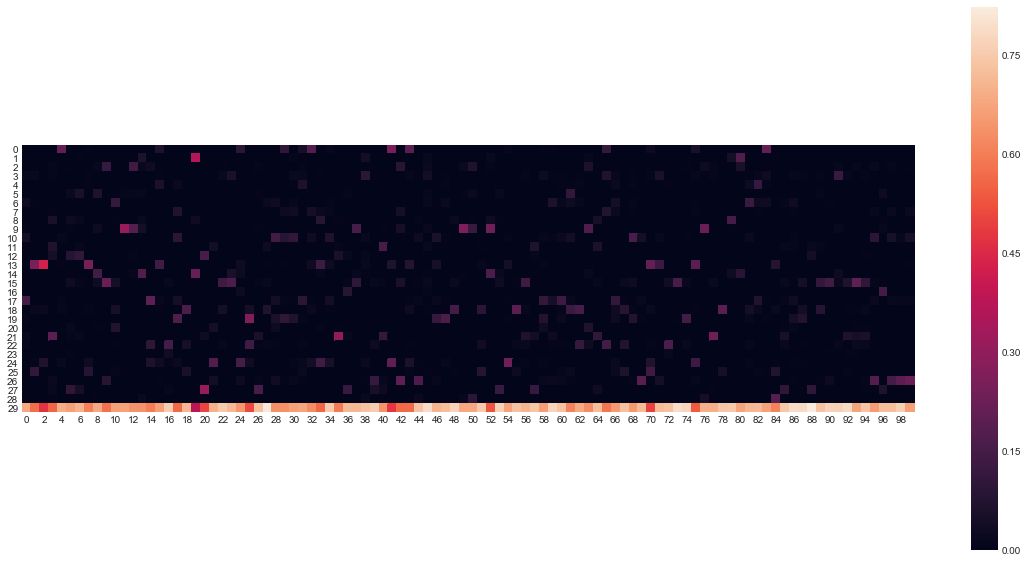

In [107]:
plt.figure(figsize=(20, 10))
seaborn.heatmap(theta.values[:, :100], square=True)

Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [116]:
probs = theta.values.mean(axis=1).reshape((-1, 1))
topics_df = pd.DataFrame(probs, columns=['Probability'])
topics_df.head(10)

,Probability
0,0.011971
1,0.012342
2,0.009094
3,0.014260
4,0.008992
5,0.010729
6,0.007117
7,0.004974
8,0.014311
9,0.022604


Найдите 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную. Укажите названия, которые вы дали этим темам.

In [117]:
topics_df.sort_values('Probability', ascending=False)

#Ваш ответ:
#5 тем с max p(t):
#3 темы с min p(t):

,Probability
29,0.658724
27,0.025206
9,0.022604
14,0.019979
17,0.016929
10,0.016311
24,0.015861
13,0.015036
8,0.014311
3,0.014260


Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

In [ ]:
# Ваш код


Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [ ]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

In [ ]:
# Ваш код


Визуализируйте найденные двумерные представления с помощью функции scatter. 

In [ ]:
# Ваш код


Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

In [ ]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, T)) # цвета для тем
# Ваш код


##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [ ]:
# Ваш код


Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [ ]:
print "http://yandex.ru"   # получится кликабельная ссылка

Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [1]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [ ]:
# Ваш код


##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 